In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("epl_event_data_15.csv")

## assess popularity of event types

<Axes: ylabel='Density'>

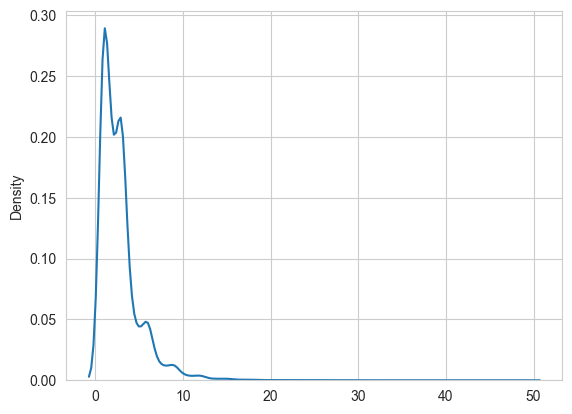

In [30]:
possession_length_count = data[["match_id","possession","player.id","id"]].groupby(["match_id","possession","player.id"],as_index=False).count()
sns.set_style('whitegrid')
sns.kdeplot(np.array(possession_length_count.id), bw_method=0.25)


C:\Users\conny\AppData\Local\Temp\ipykernel_21324\3157278829.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  hist.set_xticklabels(hist.get_xticklabels(), rotation=90);


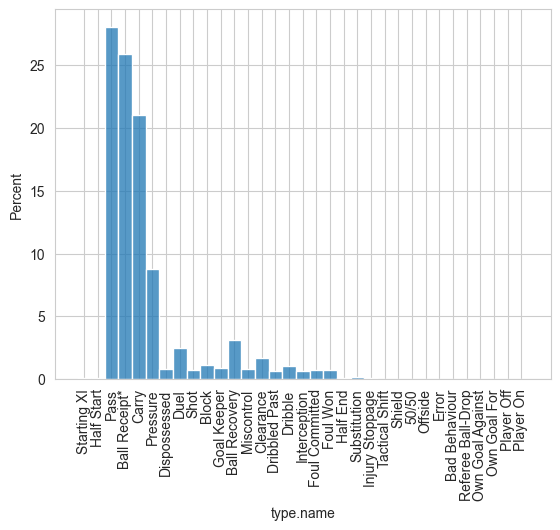

In [5]:
hist = sns.histplot(data=data, x="type.name", stat="percent")
hist.set_xticklabels(hist.get_xticklabels(), rotation=90);

In [6]:
#timestamp in time format
data.timestamp = pd.to_datetime(data.timestamp)

C:\Users\conny\AppData\Local\Temp\ipykernel_21324\1090546523.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.timestamp = pd.to_datetime(data.timestamp)


### my model will predict Foul Won based on a sequence of events

In [7]:
possession_length_count = data[["match_id","possession","player.id","id"]].groupby(["match_id","possession","player.id"],as_index=False).count()
np.mean(possession_length_count.id)

np.float64(2.7739902521720703)

In [ ]:
#chosen length of sequence, longer sequences less common
chosen_seq_length = 4

In [9]:
sum(possession_length_count.id<chosen_seq_length )

251344

In [ ]:
pos_pct = sum(possession_length_count.id<chosen_seq_length)/len(possession_length_count)
print(f"{round(pos_pct*100):.3f}% of possessions have less than {chosen_seq_length:.3f} events")

0.5326213180758635


## identify the start and end of each possession

In [11]:

main_df = pd.DataFrame(data)

## give different event types different priority for sorting, so eg a player can't receive the ball after passing it
###########################
main_df['sort_priority'] = main_df['type.name'].map({
    'Ball Receipt*': 0,
    "Ball Recovery":1,  
    'Pass': 2,
    "Foul Won":10
    
    
}).fillna(9)#give all others 9 priority (better than foul won)

# Sort with priority
main_df = main_df.sort_values(['match_id', 'timestamp', 'sort_priority'])

## identify when ball is in possession and when that possession ends
##############################
# Mark all Ball Receipt events
main_df['is_br'] = ((main_df['type.name'] == 'Ball Receipt*')|(main_df['type.name'] == 'Ball Recovery')).astype(int)

# Create possession groups
main_df['poss_group' ] = main_df['is_br'].cumsum()

# Forward-fill player.id within each possession group
main_df['possessing_player'] = (main_df['player.id']
                               .where(main_df['is_br'] == 1)
                               .groupby(main_df['poss_group'])
                               .ffill())

# Detect possession endings (Pass or new Ball Receipt)
end_conditions = (
    ((main_df['type.name'] == 'Pass') & 
    (main_df['player.id'] == main_df['possessing_player'])) | \
    ((main_df['type.name'] == 'Ball Receipt*') & 
    (main_df['player.id'] != main_df['possessing_player']))    | \
    ((main_df['type.name'] == 'Ball Recovery') & 
    (main_df['player.id'] != main_df['possessing_player'])))

# Create valid possession windows
main_df['valid_possession'] = (main_df['poss_group']
                              .isin(main_df.loc[end_conditions, 'poss_group'] - 1))

main_df['in_possession'] = (
    (main_df['possessing_player'].notna())
    .astype(int)
)
# Cleanup
main_df = main_df.drop(columns=['is_br', 'poss_group', 'valid_possession'])


### get unique id for each player possession

In [12]:
change_mask = (
    #if a player is newly in possession
    (main_df['in_possession'].diff() != 0) | 
    #or player in possession has changed
    (main_df['possessing_player'] != main_df['possessing_player'].shift())
)

#Generate possession identifiers
main_df['poss_identifier'] = (
    change_mask.cumsum() * main_df['in_possession']
).astype(int)



## get first and last event of each possession

In [13]:
main_df['move_number'] = main_df.groupby('poss_identifier').cumcount() + 1

# Identify first/last moves in possession
main_df['first_move'] = main_df['move_number'] == 1
main_df['last_move'] = False

# For last move look ahead to the next row
last_moves = main_df.groupby('poss_identifier')['timestamp'].idxmax()
main_df.loc[last_moves, 'last_move'] = True

### get features

In [14]:
#get binary variables for pressure/dribble or dribble past on a possession
main_df["pressure"] = np.where(main_df["under_pressure"],1,0)
main_df["dribble"] = np.where(main_df["type.name"]=="dribble",1,0)
main_df["dribble_past"] = np.where(main_df["type.name"]=="dribble.past",1,0)
#put events in index order, to get correct durations for each event
main_df= main_df.sort_values(["match_id", "index"])
#get duration of each event to the next one
main_df['duration_seconds'] =main_df["timestamp"].diff().dt.total_seconds().fillna(0).astype(float)



## identify plays on which there is a foul won

In [15]:
main_df['y'] = (main_df.groupby('poss_identifier')['type.name']
            .transform(lambda x: x.eq('Foul Won').any().astype(int)))
main_df = main_df[main_df["type.name"]!="Foul Won"]
# 2. For non-possession rows (poss_identifier=0), set y=0
main_df.loc[main_df['poss_identifier'] == 0, 'y'] = 0

## for possessions with a foul won: take the last n events. If no foul takes place then take any sequence of n.

In [16]:
def create_balanced_sequences(df, min_length=1, max_length=chosen_seq_length):
    sequences = []
    labels = []
    
    for pid, group in df.groupby('poss_identifier'):
        if pid == 0:
            continue
            
        events = group.sort_values('timestamp')
        n_events = len(events)
        y = group['y'].iloc[0]
        
        # Handle all possessions with >= min_length events
        if n_events >= min_length:
            window_size = min(max_length, n_events)
            
            if y == 1:
                # For fouls: take last 'window_size' events
                window = events.iloc[-window_size:]
            else:
                # For non-fouls: random window
                start = np.random.randint(0, n_events - window_size + 1)
                window = events.iloc[start:start+window_size]
            
            # Pad if less than 4
            features = window[['pressure', 'dribble', 'dribble_past', 'duration_seconds']].values
            if len(features) < max_length:
                features = np.pad(features, ((max_length-len(features),0),(0,0)), mode='constant')
            
            sequences.append(features.flatten())
            labels.append(y)
    
    return np.array(sequences), np.array(labels)

In [ ]:

X, y = create_balanced_sequences(main_df)


# Reshape for LSTM (samples, timesteps, features)
X_reshaped = X.reshape((X.shape[0], chosen_seq_length, 4))  # n timesteps, 4 features per event

# 3. Train/Test Split ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_reshaped, y, test_size=0.25, stratify=y, random_state=43
)


# Scale per-feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 4)).reshape(X_train.shape)
X_val_scaled = scaler.fit_transform(X_val.reshape(-1, 4)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 4)).reshape(X_test.shape)


In [18]:


#Build LSTM Model 
model = Sequential([
    LSTM(64, input_shape=(chosen_seq_length, 4), return_sequences=True, recurrent_dropout=0.2),
    Dropout(0.3),
    LSTM(32, recurrent_dropout=0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss=BinaryFocalCrossentropy(gamma=2),# better results than binary_crossentropy
    optimizer='adam',
    metrics=[Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='pr_auc', curve='PR'), ]#metrics that best suit sparse classification
)

# add class weights improve representation of fouls won. 25% x size difference chosen after experimentation
class_weights = {0: 1, 1: 0.25
                 *(len(y_train[y_train==0])/len(y_train[y_train==1]))}  
history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    class_weight=class_weights
)

results = model.evaluate(X_test_scaled, y_test)


C:\Users\conny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
8717/8717 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step - loss: 0.1376 - pr_auc: 0.0934 - precision: 0.1551 - recall: 0.1938 - val_loss: 0.0578 - val_pr_auc: 0.1356 - val_precision: 0.1501 - val_recall: 0.3682
Epoch 2/20
8717/8717 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.1219 - pr_auc: 0.1331 - precision: 0.1559 - recall: 0.3596 - val_loss: 0.0621 - val_pr_auc: 0.1630 - val_precision: 0.1811 - val_recall: 0.3882
Epoch 3/20
8717/8717 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.1149 - pr_auc: 0.1627 - precision: 0.1855 - recall: 0.4070 - val_loss: 0.0438 - val_pr_auc: 0.1847 - val_precision: 0.2550 - val_recall: 0.3415
Epoch 4/20
8717/8717 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 0.1154 - pr_auc: 0.1759 - precision: 0.1892 - recall: 0.4145 - val_loss: 0.0455 - val_pr_auc: 0.2007 - val_precision: 0.2271 - val_recall: 0.4006
Epoch 5/20
8717/8717 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.1133 - pr_auc: 0.1750 - precision: 0.1897 - recall: 0.4159 - val_loss: 0.0436 - val_pr_auc: 0.2062

In [19]:
print(f"Test Loss: {results[0]:.3f}")
print(f"Test AUC-PR: {results[3]:.3f}")
print(f"Test Precision: {results[1]:.3f}")
print(f"Test Recall: {results[2]:.3f}")

Test Loss: 0.045
Test AUC-PR: 0.228
Test Precision: 0.209
Test Recall: 0.479


In [27]:
print(f"Where the model predicts a foul won {round(results[1]*100,2):.3f}% are fouls won and of the fouls won in the data it calls {round(results[2]*100,2):.3f}% fouls won")


Where the model predicts a foul won 20.870% are fouls won and of the fouls won in the data it calls 47.860% fouls won


## ROC AND PR Curves, more space under the line is better

2325/2325 ━━━━━━━━━━━━━━━━━━━━ 90s 38ms/step


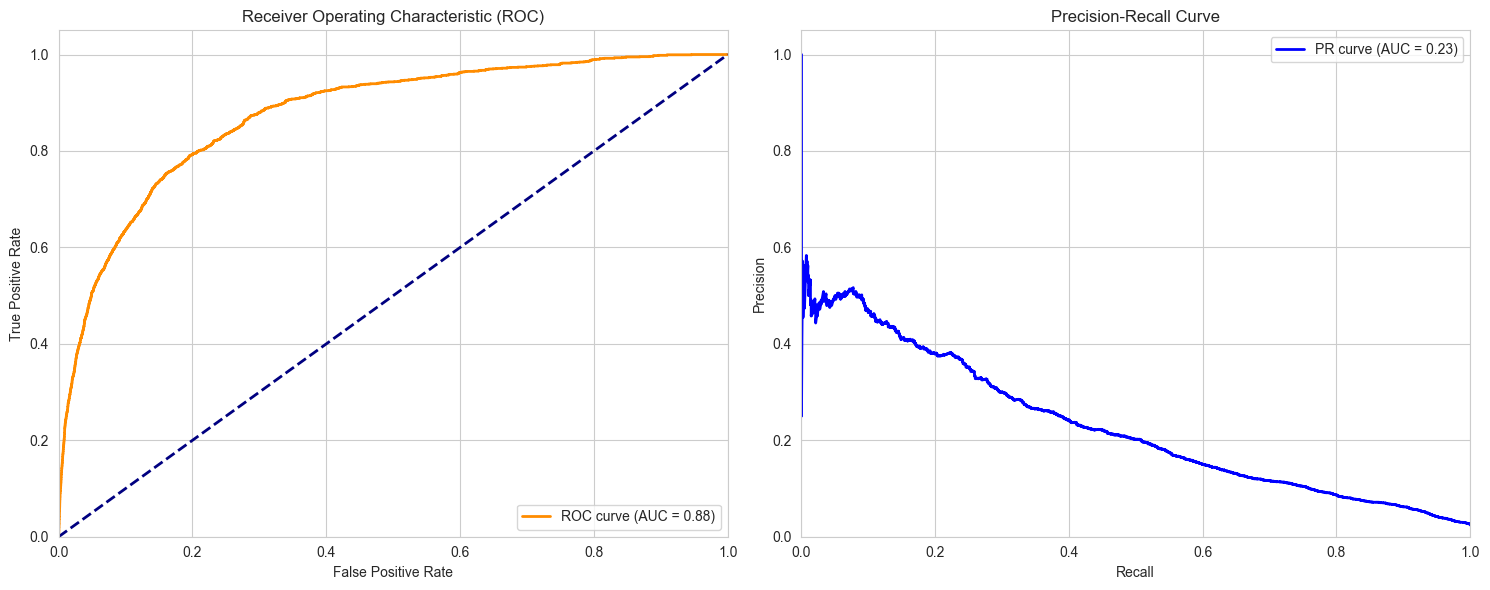

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Get predicted probabilities
y_probs = model.predict(X_test_scaled).ravel()

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc="lower right")

# Plot Precision-Recall Curve
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()